In [9]:
# 코드 작성일 : 24.8.17
# 1의 비중이 너무 적어서 예측도 잘 안되고, recall도 너무 낮당 ㅠ  
import os

if 'original_dir' not in globals() :
    original_dir = os.getcwd()
    original_dir = os.path.dirname(os.path.dirname((os.path.dirname(original_dir))))
    os.chdir(original_dir)
from setup.default import *


In [10]:
df = pd.read_csv(original_dir+'/data/preproc/main/feature_lab_v1/menu_w_soldout_w_soldout_ratio.csv')

In [11]:
from sklearn.preprocessing import StandardScaler
# 결측치 처리
df.loc[:,'course_kcal'] = df['course_kcal'].fillna(df['course_kcal'].mean().astype(int))
df.loc[:,'course_protein'] = df['course_protein'].fillna(df['course_protein'].mean().astype(int))
df.loc[:, 'course_na'] = df['course_na'].apply(lambda x: int(x) if pd.notna(x) else np.nan)
df.loc[:,'course_na'] = df['course_na'].fillna(df['course_na'].mean().astype(int))
# df.loc[:,'soldout_ratio'] = df['soldout_ratio'].fillna(df['soldout_ratio'].mean().astype(int))
# df.loc[:,'soldout_ratio_c'] = df['soldout_ratio_c'].fillna(df['soldout_ratio_c'].mean().astype(int))
df.loc[:,'soldout_ratio'] = df['soldout_ratio'].fillna(-1)
df.loc[:,'soldout_ratio_c'] = df['soldout_ratio_c'].fillna(-1)



# 루트 화
df['sim_menu'] = np.sqrt(df['sim_menu'])
df['sim_menu_c'] = np.sqrt(df['sim_menu_c'])

# StandardScaler를 사용하여 표준 정규 분포로 변환
columns_to_scale = ['course_kcal', 'course_protein', 'course_na']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# 이탈이 높은 화요일만 강조
df['day_of_week'] = [1 if s =='Tuesday' else 0 for s in df['day_of_week']]


# 특징과 타겟 변수 설정
df['day'] = pd.to_datetime(df['day'])

test_data = df[(df['day'] >= '2024-04-01')]
train_data = df[(df['day'] < '2024-04-01')]

# 피처와 타겟 분리
X_train = train_data.drop(columns=['post_no','day','meal_time','is_soldout', 'course', 'soldout','soldout_time','first_menu_unpreproc',\
                                   'first_menu','menu_no','only_menu_2','only_menu_2_soldout','course_no_c','only_menu_2_c','only_menu_2_soldout_c'])
y_train = train_data['is_soldout'].astype(int)

# y_train이 1인 샘플의 ##배를 무작위로 샘플링하여 추가 (##배로 증강)
X_train_1 = X_train[y_train == 1]
y_train_1 = y_train[y_train == 1]

X_train_1_resampled, y_train_1_resampled = resample(X_train_1, y_train_1,
                                                     replace=True,
                                                     n_samples=int(len(X_train_1) * 0.), # 몇배 증강?
                                                     random_state=None)

# 기존 X_train, y_train과 결합
X_train_resampled = pd.concat([X_train])#, X_train_1_resampled])
y_train_resampled = pd.concat([y_train])#, y_train_1_resampled])

X_test = test_data.drop(columns=['post_no','day','meal_time','is_soldout', 'course', 'soldout','soldout_time','first_menu_unpreproc',\
                                   'first_menu','menu_no','only_menu_2','only_menu_2_soldout','course_no_c','only_menu_2_c','only_menu_2_soldout_c'])
y_test = test_data['is_soldout'].astype(int)

# 범주형 변수 인코딩 및 스케일링
#numeric_features = ['course_kcal', 'course_protein', 'course_na','sim_menu','sim_menu_c','soldout_ratio','soldout_ratio_c','day_of_week']
numeric_features = ['sim_menu','sim_menu_c','soldout_ratio','soldout_ratio_c']#,'day_of_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)#,
        #('cat', OneHotEncoder(), categorical_features)
    ]
)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imPipeline
# 랜덤 포레스트 모델
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=1234
)
# n_estimators : 트리 몇개 만드는지!
# class_weight : 클래스 간의 데이터 불균형을 처리하기 위해 클래스 가중치를 자동으로 조정하는 옵션입니다.
# random_state : 시드
# max_depth : 트리 최대 깊이 
# min_samples_split : 노드 분할시 최소 샘플수
# 파이프라인 구성
pipeline = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# 모델 훈련
pipeline.fit(X_train, y_train)

# 예측
#y_pred = pipeline.predict(X_test)

# 예측 확률
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# 임계값 조정
threshold = 0.5  # 예를 들어, 0.3으로 조정
y_pred = (y_pred_prob >= threshold).astype(int)

print("test")
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
print(f'# of soldout : ', y_pred.sum())

# 결과 평가
# 훈련 데이터에 대한 예측
y_train_prob = pipeline.predict_proba(X_train_resampled)[:, 1]
y_train_pred = (y_train_prob >= threshold).astype(int)

# 훈련 데이터에 대한 정확도
print("train")
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')
print('Training Classification Report:')
print(classification_report(y_train_resampled, y_train_pred))
print(f'# of soldout in Training Data: ', y_train_pred.sum())



test
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.72      0.83      0.77        41
           1       0.59      0.43      0.50        23

    accuracy                           0.69        64
   macro avg       0.66      0.63      0.64        64
weighted avg       0.67      0.69      0.67        64

# of soldout :  17
train
Training Accuracy: 0.7467532467532467
Training Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       207
           1       0.60      0.66      0.63       101

    accuracy                           0.75       308
   macro avg       0.72      0.73      0.72       308
weighted avg       0.75      0.75      0.75       308

# of soldout in Training Data:  111


In [13]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드 설정
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__class_weight': ['balanced', None]
}

# 그리드 서치
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 파라미터
print(f'Best Parameters: {grid_search.best_params_}')

# 최적의 모델로 예측
y_pred = grid_search.predict(X_test)

# 예측 확률
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# 임계값 조정
threshold = 0.4  # 예를 들어, 0.3으로 조정
y_pred = (y_pred_prob >= threshold).astype(int)


# 결과 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
print(f'# of soldout : ', y_pred.sum())


KeyboardInterrupt: 

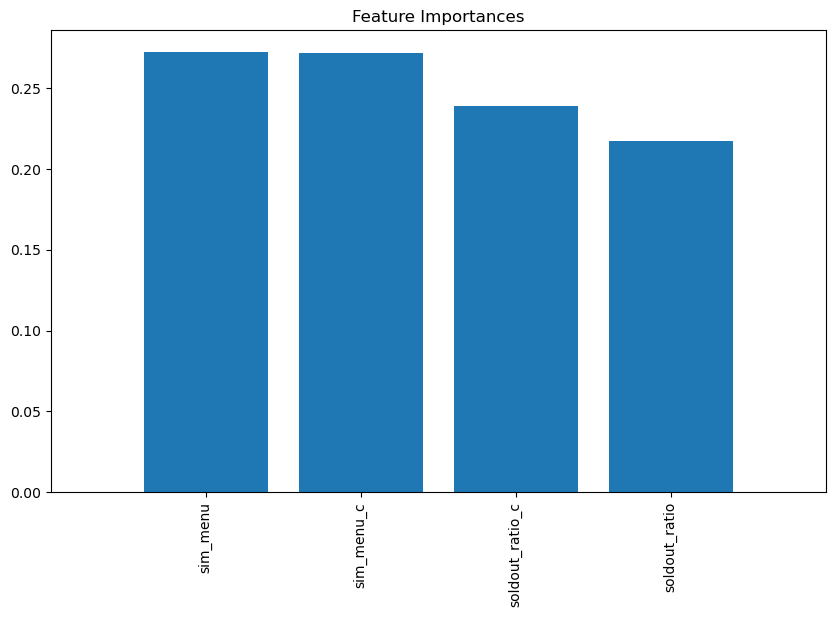

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 훈련된 모델의 피처 중요도 추출
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# 피처 이름 추출
preprocessor_feature_names = (pipeline.named_steps['preprocessor']
                               .transformers_[0][1].get_feature_names_out().tolist())# +
                            #   pipeline.named_steps['preprocessor']
                            #   .transformers_[1][1].get_feature_names_out().tolist())

# 중요도와 피처 이름을 데이터프레임으로 변환
importances = np.array(feature_importances)
indices = np.argsort(importances)[::-1]
features = np.array(preprocessor_feature_names)[indices]
importances = importances[indices]

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(features)), importances, align='center')
plt.xticks(range(len(features)), features, rotation=90)
plt.xlim([-1, len(features)])
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


# KNN 모델
knn = KNeighborsClassifier()

# 파이프라인 구성
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn)
])

# 하이퍼파라미터 그리드 설정
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# 그리드 서치
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 파라미터
print(f'Best Parameters: {grid_search.best_params_}')

# 최적의 모델로 예측
y_pred = grid_search.predict(X_test)

# 예측 확률
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

# 임계값 조정
threshold = 0.5  # 예를 들어, 0.4으로 조정
y_pred = (y_pred_prob >= threshold).astype(int)

# 결과 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
print(f'# of soldout : ', y_pred.sum())


Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.70      0.73      0.71        41
           1       0.48      0.43      0.45        23

    accuracy                           0.62        64
   macro avg       0.59      0.58      0.58        64
weighted avg       0.62      0.62      0.62        64

# of soldout :  21
